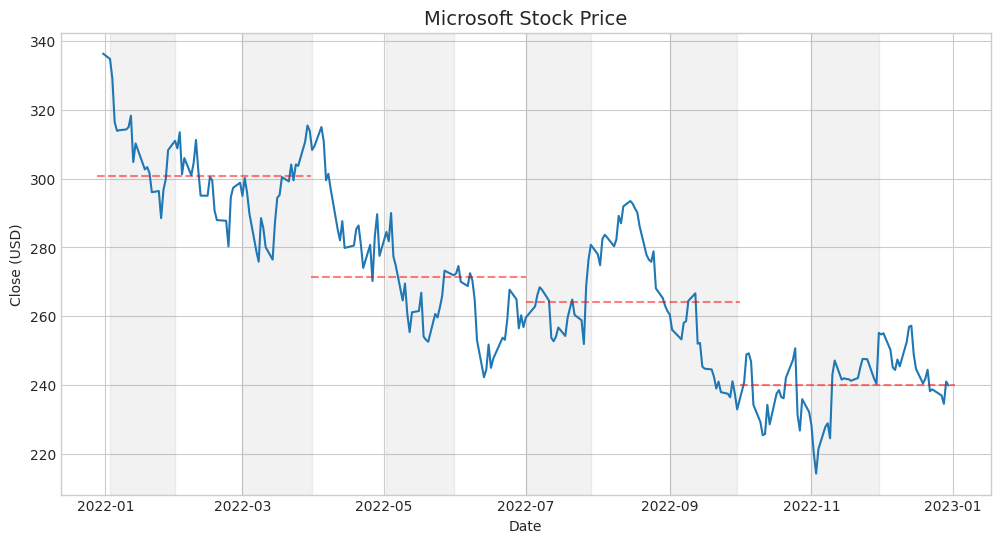

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv('MSFT.csv',infer_datetime_format=True, parse_dates=['Date'])
# drop NA values
data = data.dropna()

# Convert date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Create figure and axis objects
fig, ax = plt.subplots(1, figsize=(12, 6))

# Plot the data
ax.plot(data['Date'], data['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Close (USD)')
ax.set_title('Microsoft Stock Price',size=14)



# Add shaded strips for each month
for year in range(data['Date'].dt.year.min(), data['Date'].dt.year.max()+1):
    for month in range(1, 13,2):
        month_data = data[(data['Date'].dt.year == year) & (data['Date'].dt.month == month)]
        if not month_data.empty:
            start_date = month_data['Date'].min()
            end_date = month_data['Date'].max()
            ax.axvspan(start_date, end_date, alpha=0.1, color='gray')
# resample to quarterly frequency and calculate the mean
quarterly_mean = data.resample('Q', on='Date')['Close'].mean()

# put the means into a list
mn = quarterly_mean.tolist()
    
for s in range(4):
    ax.axhline(y=mn[s+1], color='red', linestyle='--', xmin=(1+6*s)/26, xmax=(7+6*s)/26, alpha=0.5)
    


# Show the plot
plt.show()

In [4]:
import pandas as pd
from sklearn import linear_model

#Read the data into a pandas DataFrame and convert it to stationarity
df = pd.read_csv('MSFT.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])


df['Close_diff'] = df['Close'].diff().diff()

In [5]:
df

,Close,Close_diff
Date,,
2021-12-31,336.320007,NaN
2022-01-03,334.750000,NaN
2022-01-04,329.010010,-4.169983
2022-01-05,316.380005,-6.890015
2022-01-06,313.880005,10.130005
...,...,...
2022-12-23,238.729996,6.779985
2022-12-27,236.960007,-2.309983
2022-12-28,234.529999,-0.660019


In [6]:
#add two columns containing the LAG=1 and LAG=2 version of the data to the DataFrame
df['T_(i-1)'] = df['Close_diff'].shift(1)
df['T_(i-2)'] = df['Close_diff'].shift(2)

In [7]:
#drop the top four rows as they contain NaNs after shifting
df = df.drop(df.index[[0, 1, 2, 3]])

In [8]:
#fit a linear regression model on T_i and T_i-1 and add it's predictions to the DataFrame as a new column
lm = linear_model.LinearRegression()
df_X = df['T_(i-1)'].values.reshape(-1, 1)
df_y = df['Close_diff'].values.reshape(-1, 1)
model = lm.fit(df_X,df_y)
df['Predicted_T_i|T_(i-1)'] = lm.predict(df_X)

In [9]:
df

,Close,Close_diff,T_(i-1),T_(i-2),Predicted_T_i|T_(i-1)
Date,,,,,
2022-01-06,313.880005,10.130005,-6.890015,-4.169983,3.403092
2022-01-07,314.040009,2.660004,10.130005,-6.890015,-4.830544
2022-01-10,314.269989,0.069976,2.660004,10.130005,-1.216842
2022-01-11,314.980011,0.480042,0.069976,2.660004,0.036114
2022-01-12,318.269989,2.579956,0.480042,0.069976,-0.162260
...,...,...,...,...,...
2022-12-23,238.729996,6.779985,-8.869981,1.279984,4.360924
2022-12-27,236.960007,-2.309983,6.779985,-8.869981,-3.209932
2022-12-28,234.529999,-0.660019,-2.309983,6.779985,1.187448


In [10]:
#create the time series of residuals corresponding to the predictions of this model and add it to the DataFrame.
# This gives us the first one of the two time series we need for calculating the PACF for X at LAG=2
#Observed minus predicted
df['Residual_T_i|T_(i-1)'] = df['Close_diff'] - df['Predicted_T_i|T_(i-1)']

In [11]:
# #repeat the above procedure to calculate the second time series of residuals
lm = linear_model.LinearRegression()
df_X = df[['T_(i-1)']] #Note the double brackets! [[]]
df_y = df['T_(i-2)'] #Note the single brackets! []
model = lm.fit(df_X,df_y)
df['Predicted_T_(i-2)|T_(i-1)'] = lm.predict(df_X)
#Observed minus predicted
df['Residual_T_(i-2)|T_(i-1)'] = df['T_(i-2)'] - df['Predicted_T_(i-2)|T_(i-1)']

#Finally, apply the formula for Pearson's r to the two time series of residuals to get the value of the PACF at LAG=2
print(df.corr(method='pearson')['Residual_T_i|T_(i-1)']['Residual_T_(i-2)|T_(i-1)'])

-0.31214641310046


In [12]:
# Question: Based on the above process, please complete the partial correlation for Apple 
# close stock prices with lag 2 from scratch and test its result by using statsmodels library.

import pandas as pd
from sklearn import linear_model

#Read the data into a pandas DataFrame and convert it to stationarity
df = pd.read_csv('MSFT.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df['Close_diff'] = df['Close'].diff().diff()
#add two columns containing the LAG=1 and LAG=2 version of the data to the DataFrame
df['T_(i-1)'] = df['Close_diff'].shift(1)
df['T_(i-2)'] = df['Close_diff'].shift(2)
#drop the top four rows as they contain NaNs after shifting
df = df.drop(df.index[[0, 1, 2, 3]])
#fit a linear regression model on T_i and T_i-1 and add it's predictions to the DataFrame as a new column
lm = linear_model.LinearRegression()
df_X = df[['T_(i-1)']] #Note the double brackets! [[]]
df_y = df['Close_diff'] #Note the single brackets! []
model = lm.fit(df_X,df_y)
df['Predicted_T_i|T_(i-1)'] = lm.predict(df_X)
#create the time series of residuals corresponding to the predictions of this model and add it to the DataFrame.
# This gives us the first one of the two time series we need for calculating the PACF for X at LAG=2
#Observed minus predicted
df['Residual_T_i|T_(i-1)'] = df['Close_diff'] - df['Predicted_T_i|T_(i-1)']
# #repeat the above procedure to calculate the second time series of residuals
lm = linear_model.LinearRegression()
df_X = df[['T_(i-1)']] #Note the double brackets! [[]]
df_y = df['T_(i-2)'] #Note the single brackets! []
model = lm.fit(df_X,df_y)
df['Predicted_T_(i-2)|T_(i-1)'] = lm.predict(df_X)
#Observed minus predicted
df['Residual_T_(i-2)|T_(i-1)'] = df['T_(i-2)'] - df['Predicted_T_(i-2)|T_(i-1)']

#Finally, apply the formula for Pearson's r to the two time series of residuals to get the value of the PACF at LAG=2
print(df.corr(method='pearson')['Residual_T_i|T_(i-1)']['Residual_T_(i-2)|T_(i-1)'])

-0.31214641310046


### Implementing AR from scratch

In [13]:
%pip install statsmodels


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn

In [15]:
df=pd.read_csv('MSFT.csv', parse_dates=['Date'], index_col=['Date'], dayfirst=True)
df.columns=['Close']

In [16]:
df

,Close
Date,
2021-12-31,336.320007
2022-01-03,334.750000
2022-01-04,329.010010
2022-01-05,316.380005
2022-01-06,313.880005
...,...
2022-12-23,238.729996
2022-12-27,236.960007
2022-12-28,234.529999


In [17]:
def AR(p,df):
    df_temp = df

    #Lag feature generation: Generating the lagged p terms
    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp['Close'].shift(i) 
    
    train_size = (int)(0.7 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()
    #X contains the lagged values ,hence we skip some rows
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)

    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)
    #Running linear regression to generate the coefficents of lagged terms
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    
    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # df_train_2[['Value','Predicted_Values']].plot()

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    # df_test[['Value','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(df_test['Close'], df_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of p : ",p)
    return [df_train_2,df_test,theta,intercept,RMSE]

In [18]:
lag_num = 1

In [19]:
[df_train,df_test,theta,intercept,RMSE] = AR(lag_num,pd.DataFrame(df.Close))

The RMSE is : 5.905766692988994 , Value of p :  1


/tmp/ipykernel_10108/370193012.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 3000x1800 with 0 Axes>

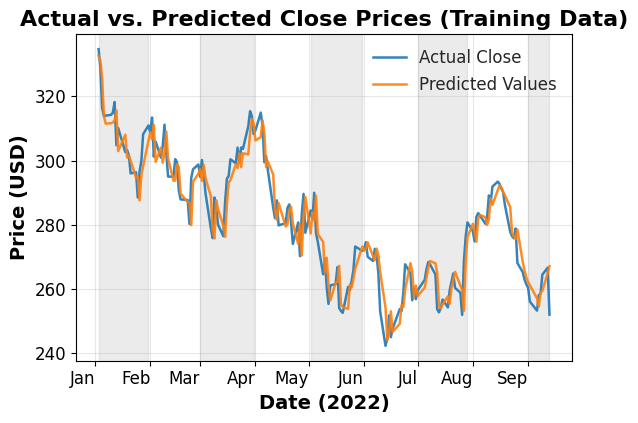

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Set the figure size and resolution
plt.figure(figsize=(10, 6), dpi=300)

# Plot the actual Close prices and predicted values
df_train[['Close','Predicted_Values']].plot(linewidth=1.8, alpha=0.9, color=['tab:blue', 'tab:orange'])

# Add axis labels and title with custom font size
plt.xlabel('Date (2022)', fontsize=14, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=14, fontweight='bold')
plt.title('Actual vs. Predicted Close Prices (Training Data)', fontsize=16, fontweight='bold')

# Customize the plot style and color
plt.style.use('seaborn-whitegrid')
plt.grid(alpha=0.3)
plt.legend(['Actual Close', 'Predicted Values'], loc='best', fontsize=12)

# Set font size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=0)


# Set x-axis tick label format to show only month and year
def date_formatter(x, pos):
    return mdates.num2date(x).strftime('%b')

plt.gca().xaxis.set_major_formatter(FuncFormatter(date_formatter))

# Add transparent regions for each month
months = df_train.index.strftime('%m').unique()
for month in months[::2]:
    month_mask = df_train.index.strftime('%m') == month
    month_start = df_train.index[month_mask][0]
    month_end = df_train.index[month_mask][-1]
    plt.axvspan(month_start, month_end, color='tab:gray', alpha=0.15)

# Save the plot as a PNG file
plt.savefig('actual_predicted_prices.png', bbox_inches='tight')


/tmp/ipykernel_10108/1665102287.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 2400x1800 with 0 Axes>

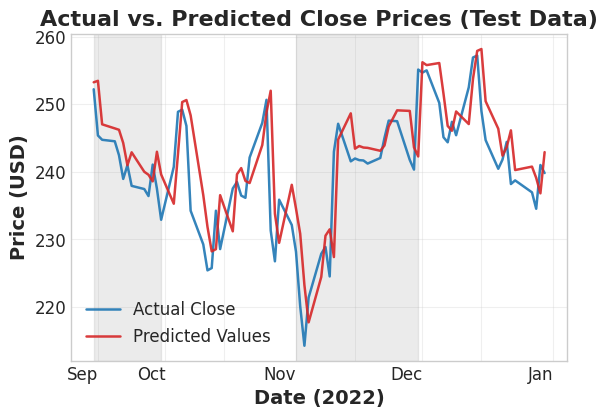

In [21]:
# Set the figure size and resolution
plt.figure(figsize=(8, 6), dpi=300)

# Plot the actual Close prices and predicted values
df_test[['Close','Predicted_Values']].plot(linewidth=1.8, alpha=0.9, color=['tab:blue', 'tab:red'])

# Add axis labels and title with custom font size
plt.xlabel('Date (2022)', fontsize=14, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=14, fontweight='bold')
plt.title('Actual vs. Predicted Close Prices (Test Data)', fontsize=16, fontweight='bold')

# Customize the plot style and color
plt.style.use('seaborn-whitegrid')
plt.grid(alpha=0.3)
plt.legend(['Actual Close', 'Predicted Values'], loc='best', fontsize=12)

# Set font size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set x-axis tick label format to show only month and year
prev_month = None

def date_formatter(x, pos):
    global prev_month
    curr_month = mdates.num2date(x).strftime('%b')
    if curr_month != prev_month:
        prev_month = curr_month
        return mdates.num2date(x).strftime('%b')
    else:
        return ''

plt.gca().xaxis.set_major_formatter(FuncFormatter(date_formatter))

# Remove rotation of x-axis tick labels
plt.xticks(rotation=0)
# Add transparent regions for each month


# Save the plot as a PNG file
plt.savefig('actual_predicted_prices.png', bbox_inches='tight')
months = df_test.index.strftime('%m').unique()
for month in months[::2]:
    month_mask = df_test.index.strftime('%m') == month
    month_start = df_test.index[month_mask][0]
    month_end = df_test.index[month_mask][-1]
    plt.axvspan(month_start, month_end, color='tab:gray', alpha=0.15)

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


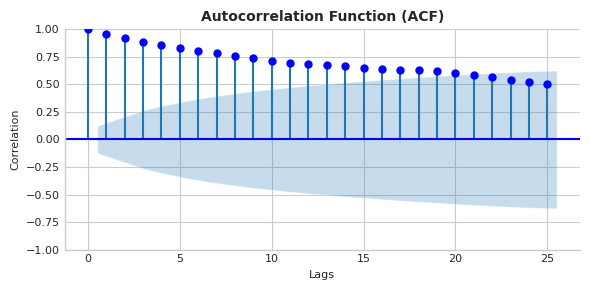

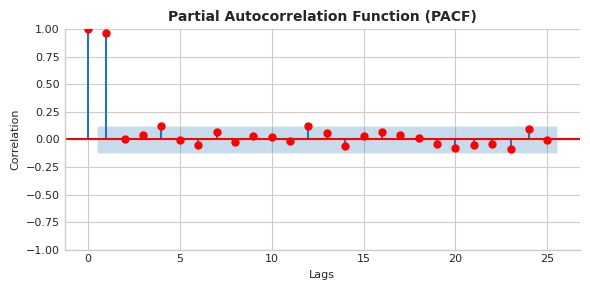

In [24]:
# Set style for all plots
sns.set_style('whitegrid')


# Plot ACF
fig, ax = plt.subplots(figsize=(6, 3))
acf = plot_acf(df.Close.dropna(), lags=25, color='blue', ax=ax)
ax.set_xlabel('Lags', fontsize=8)
ax.set_ylabel('Correlation', fontsize=8)
ax.set_title('Autocorrelation Function (ACF)', fontsize=10, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

# Plot PACF
fig, ax = plt.subplots(figsize=(6, 3))
pacf = plot_pacf(df.Close.dropna(), lags=25, color='red', ax=ax)
ax.set_xlabel('Lags', fontsize=8)
ax.set_ylabel('Correlation', fontsize=8)
ax.set_title('Partial Autocorrelation Function (PACF)', fontsize=10, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig('ACF_PACF_plot.png', dpi=300, bbox_inches='tight')